In [32]:
import numpy as np
import math
from math import * 

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter, AutoMinorLocator,NullFormatter,LogLocator)
majorFormatter = FormatStrFormatter('%d')
from matplotlib import rc

from scipy import integrate
from scipy import special, integrate
from scipy import interpolate as spi
from scipy.special import zeta
from scipy.integrate import odeint, solve_ivp, quad
from scipy.special import kn #modified Bessel function of the second kind, order n
from scipy.interpolate import interp1d
from scipy.optimize import minimize_scalar, root_scalar

import pandas as pd

from IPython.display import display, Markdown
import time
import csv
import os

plt.rc('text', usetex=True)
plt.rc('font', family='serif', size=12)

In [33]:
def Tmax(T_i,m_i,m_chi): 
    return ((T_i**2)+(2*m_i*T_i))/(T_i+(((m_i+m_chi)**2)/(2*m_chi)))

def T_i_min(T_j, m_i, m_j, positive_branch=True):
    term1 = (T_j / 2) - m_i
    term2_numerator = (m_i + m_j) ** 2
    term2_denominator = (T_j - 2 * m_i) ** 2
    term2_fraction = (2 * T_j) / m_j
    square_root_arg = 1 + (term2_numerator / term2_denominator) * term2_fraction
    
    if square_root_arg < 0:
        raise ValueError("Square root argument must be non-negative.")
    
    if positive_branch:
        sqrt_value = np.sqrt(square_root_arg)
    else:
        sqrt_value = -np.sqrt(square_root_arg)
    
    result = term1 * (1 + sqrt_value)
    return result


import numpy as np
from scipy.integrate import dblquad

def dPhi_dT_chi(T_chi, sigma_chi_p, Sigma_DM_tot, m_chi, d_L, T_p):
    def integrand(phi_s, T_p):
        return (sigma_chi_p / (2 * np.pi * m_chi * d_L ** 2)) * (1 / T_chi) * (1 / T_chi_max(T_p)) * dGamma_dT_dOmega(T_p)

    def T_chi_max(T_p):
        return ((T_p**2)+(2*m_p*T_p))/(T_p+(((m_p+m_chi)**2)/(2*m_chi)))

    result, _ = dblquad(lambda T_p, phi_s: integrand(phi_s, T_p),
                        0, 2 * np.pi,
                        lambda T_p: T_i_min(T_chi),
                        lambda T_p: T_max(T_chi))
    
    return Sigma_DM_tot * result


# Example usage:
# Define your T_p_min, T_p_max, and dGamma_dT_dOmega functions appropriately
# T_p_min(T_chi) should return the minimum value of T_p for a given T_chi
# T_p_max(T_chi) should return the maximum value of T_p for a given T_chi
# dGamma_dT_dOmega(T_p) should return the derivative of Gamma_p with respect to T_p and Omega for a given T_p

# Example usage of the function:
# result = dPhi_dT_chi(T_chi_value, sigma_chi_p_value, Sigma_DM_tot_value, m_chi_value, d_L_value, T_p_min, T_p_max, dGamma_dT_dOmega)

In [34]:
### DM profile

gamma_MW=1
r_0_MW=20 ##kpc
M_BH_MW=4.3*1e6 ##Solar masses
Delta_MBH_MW=1.2*1e4 ##Solar masses
alpha_g_MW=0.1 
R_s_MW=0.00000041165 ##pc

def rho_0(Delta_MBH,M_BH,r_0,gamma,alpha_g, R_s):
    R_S=R_s*3.08567758128e18
    R_0=1e5*R_S ##cm
    R_min=100*R_S ##cm
    M_BH5 = M_BH*1.98847e33*5.62*1e23*5.06*1e13 ##cm**-1
    Delta_MBH5=Delta_MBH*1.98847e33*5.62*1e23*5.06*1e13 ##cm**-1
    r_05=r_0*1e3*3.08567758128e18 ##cm
    #alpha_g = 0.1
    gamma_sp = (9-(2*gamma))/(4-gamma)
    R_prime_sp = alpha_g*r_05*(M_BH5/(r_05**3))**(1/(3-gamma)) ##cm
    return (((3-gamma_sp)*Delta_MBH5/(4*math.pi*R_prime_sp**(gamma_sp-gamma)*r_05**gamma
                                    *(R_0**(3-gamma_sp)-R_min**(3-gamma_sp))))**(4-gamma))*1.98*1e-14#*1e37

def rho_DM_NFW(r,rho_02,r_02,gamma, R_s):
    
    return (rho_02*(r/(r_02*1e3))**(-gamma)*(1+(r/(r_02*1e3)))**(-(3-gamma)))*((1-(4*R_s/r))**3)


def R_spike(M_BH, rho_01,r_01,gamma, alpha_g):
    ## Solar masses
    return alpha_g*(r_01*1e3)*(M_BH*1.98847e33*5.62*1e23/(rho_01*(r_01*3.08567758128e21)**3))**(1/(3-gamma)) ##pc*(GeV*cm^3/GeV*cm**3)**1/3

def rho_spike(r, M_BH, rho_0,r_0,gamma, alpha_g, R_s):
    
    R_sp=alpha_g*r_0*1e3*(M_BH*1.98847e33*5.62*1e23/(rho_0*(r_0*3.08567758128e21)**3))**(1/(3-gamma)) ##kpc*(GeV*cm^3/GeV*kpc**3)**1/3
    if r<4*R_s:
        return 0
    elif 4*R_s<r<R_spike(M_BH, rho_0,r_0,gamma, alpha_g):
        return rho_0*(R_sp/(r_0*1e3))**(-gamma)*(R_sp/r)**((9-(2*gamma))/(4-gamma))*(1-(4*R_s/r))**3
    else:
        return rho_DM_NFW(r,rho_0,r_0,gamma, R_s)
    
#### Column density of dark matter as a function of proton acceleration region

def rho_DM_ann(r,m_DM,sigma,tBH, rho_0, r_0, gamma):
    rho_core=m_DM/(sigma*tBH)
    return rho_spike(r,rho_0,r_0,gamma)*rho_core/(rho_spike(r,rho_0,r_0,gamma)+rho_core)

def integrated_rho_DM_spikeNFW(m_DM,sigma,tBH,Rem, rho_0, r_0, gamma):
    
    Rmax = R_spike(rho_0,r_0,gamma)
    
    return integrate.quad(lambda x: rho_DM_ann(x,m_DM,sigma,tBH),Rem,Rmax)[0]+integrate.quad(lambda x: rho_DM_NFW(x,rho_0_NGC,r_0_NGC,gamma_NGC),Rmax,1e4)[0]

## ANALYTICAL FORMULA COLUMN DENSITY

def Sigma_DM(M_BH, Rem, rho_0, r_0, gamma, alpha_g):

    return 3.086e18*M_BH**((gamma-3)/(gamma-4))*r_0**(gamma/(4-gamma))*Rem**((5-gamma)/(gamma-4))*alpha_g**(-(gamma-3)**2/(gamma-4))*rho0**(1/(4-gamma))*(1+(1/(gamma-5)))

In [35]:
###Blazar flux


def Blazar_flux(Tp):

    z = 0.337
    DL = 1835.4  # Mpc
    MBH = 3.09e8  # Solar masses
    D = 40  # Doppler factor
    GammaB = 20
    thetaLOS = 0  # degrees
    alphap = 2.0
    gmin_p = 1.0
    gmax_p = 5.5e7
    Lp = 2.55e48 
    mp=0.938
    cp=1
    mu=1
    betaB = math.sqrt(1 - 1 / (GammaB ** 2))
    betap = (1-(mp**2/((Tp+mp)**2)))**(1/2)
    term1 = (1 / (4 * math.pi)) * cp * math.pow((1 + Tp / mp), -alphap)
    term2_numerator = betap * math.pow((1 - betap * betaB * mu), -alphap) * math.pow(GammaB, -alphap)
    term2_denominator = math.sqrt(math.pow((1 - betap * betaB * mu), 2) - math.pow((1 - math.pow(betap, 2)) * (1 - math.pow(betaB, 2)), 2))
    result = term1 * term2_numerator / term2_denominator
    return Lp*result

def cut_offs(p, p_S, p_L, mu):

    result = (p / p_S)**(2 - mu) * math.exp(-p_S / p - p / p_L)
    return result

def Blazar_flux_low_energy_cutoff(Tp):

    z = 0.337
    DL = 1e-2  # Mpc
    MBH = 4.3*1e6  # Solar masses
    D = 40  # Doppler factor
    GammaB = 20
    thetaLOS = 0  # degrees
    alphap = 2.0
    gmin_p = 1.0
    gmax_p = 5.5e7
    Lp = 2.55e48
    mp=0.938
    cp=1
    mu=1
    betaB = math.sqrt(1 - 1 / (GammaB ** 2))
    betap = (1-(mp**2/((Tp+mp)**2)))**(1/2)
    term1 = (1 / (4 * math.pi)) * cp * math.pow((1 + Tp / mp), -alphap)
    term2_numerator = betap * math.pow((1 - betap * betaB * mu), -alphap) * math.pow(GammaB, -alphap)
    term2_denominator = math.sqrt(math.pow((1 - betap * betaB * mu), 2) - math.pow((1 - math.pow(betap, 2)) * (1 - math.pow(betaB, 2)), 2))
    result = term1 * term2_numerator / term2_denominator
    return cut_offs(Tp,9e2,1e7,4)*Lp*result

## Different cosmic ray index
def Blazar_flux_2(Tp):

    z = 0.337
    DL = 1835.4  # Mpc
    MBH = 3.09e8  # Solar masses
    D = 40  # Doppler factor
    GammaB = 20
    thetaLOS = 0  # degrees
    alphap = 2.4
    gmin_p = 1.0
    gmax_p = 5.5e7
    Lp = 2.55e48 
    mp=0.938
    cp=1
    mu=1
    betaB = math.sqrt(1 - 1 / (GammaB ** 2))
    betap = (1-(mp**2/((Tp+mp)**2)))**(1/2)
    term1 = (1 / (4 * math.pi)) * cp * math.pow((1 + Tp / mp), -alphap)
    term2_numerator = betap * math.pow((1 - betap * betaB * mu), -alphap) * math.pow(GammaB, -alphap)
    term2_denominator = math.sqrt(math.pow((1 - betap * betaB * mu), 2) - math.pow((1 - math.pow(betap, 2)) * (1 - math.pow(betaB, 2)), 2))
    result = term1 * term2_numerator / term2_denominator
    return Lp*result


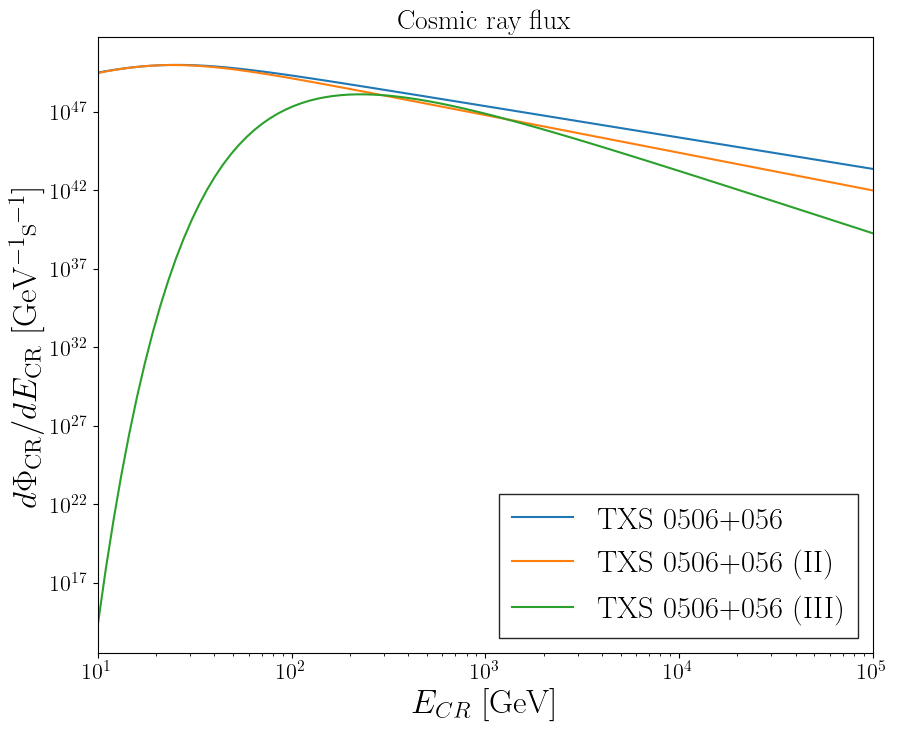

In [36]:
E_range=np.logspace(1,5,100)
##############################################################################
fig, ax1 = plt.subplots(figsize=(10,8))
plt.rc('font', family='serif')
plt.rc('text', usetex=True)

T_DM_range = np.logspace(-3,3,100)

plt.title(r"Cosmic ray flux", fontsize=20)
plt.xlabel(r"$E_{CR}$ [GeV]", fontsize=24)
plt.ylabel(r"$ d \Phi_{\rm CR}/d E_{\rm CR}$ $[\rm GeV^{-1}s^{-1}]$", fontsize=24)


plt.loglog(E_range, np.array([Blazar_flux(i) for i in E_range]), label='TXS 0506+056')
plt.loglog(E_range, np.array([Blazar_flux_2(i) for i in E_range]), label='TXS 0506+056 (II)')
plt.loglog(E_range, np.array([Blazar_flux_low_energy_cutoff(i) for i in E_range]), label='TXS 0506+056 (III)')



leg = plt.legend(loc='lower right', fancybox=0, framealpha=0.85, fontsize=22)
leg.get_frame().set_linewidth(1)
leg.get_frame().set_edgecolor('black')

axes = plt.gca()
axes.set_xlim([10, 1e5])#38
ax1.tick_params(axis='both', which='major', labelsize=16)
ax1.tick_params(axis='both', which='minor', labelsize=16)

plt.show()

In [37]:
#### IMPLEMENTATION BOOSTED INELASTIC DM FLUXES (ANDREW'S code)


In [38]:
## ATTENUATED FLUX XENON DETECTOR
################

#calculate the mean free path of DM
m_p = 0.938

#A,mass(GeV),density(cm^-3)
O = [16,14.9,3.45e22]
Si = [28,26.1,1.77e22]
mA = [24,22.3,1.17e22]
Fe = [56,52.1,6.11e22]
Ca = [40,37.2,7.94e22]
So = [23,21.4,1.47e22]
S = [32,29.8,2.33e22]
Al = [27,25.1,1.09e22]

element = np.array([[16,14.9,3.45e22],[28,26.1,1.77e22],[24,22.3,1.17e22],[56,52.1,6.11e22],[40,37.2,7.94e22],[23,21.4,1.47e22],[32,29.8,2.33e22],[27,25.1,1.09e22]])

def free_path(mdm,sigmap):
    l = 0
    for i in list(range(0,7,1)):
        l = l + element[i][2]*sigmap*element[i][0]**2*(element[i][1]/m_p)**2*((mdm+m_p)/(mdm+element[i][1]))**2*(2*element[i][1]*mdm/(element[i][1]+mdm)**2)
    l = 1/l   
    return l*1e-5    #in km

z_xenon= 1.510  #km #https://en.wikipedia.org/wiki/Large_Underground_Xenon_experiment

def attenuated_flux(T_chi_z,mdm,sigmap,z):
    
    FreePath = free_path(mdm,sigmap)
    
    denominator = 2*mdm+T_chi_z-T_chi_z*np.exp(z/FreePath)
    if denominator < 0:
        return 0
    else:
    
        T_chi0 = 2*mdm*T_chi_z*np.exp(z/FreePath)/denominator 
        dphidTz = 4*mdm**2*np.exp(z/FreePath)/(2*mdm+T_chi_z-T_chi_z*np.exp(z/FreePath))**2*flux_boosted_Tchi_MW_radial(sigmap, T_chi0, mdm, r_min=0.1, r_max=1e4, M_BH=M_BH_MW, rho_0=rho_0_MW, r_0=r_0_MW, gamma=1, alpha_g=0.1, R_s=R_s_MW)
        return dphidTz 

In [39]:
#### RATE OF EVENTS IN DM DIRECT DETECTION EXPERIMENTS

import numpy as np

#calculate the mean free path of DM
m_p = 0.938

#A,mass(GeV),density(cm^-3)
O = [16,14.9,3.45e22]
Si = [28,26.1,1.77e22]
mA = [24,22.3,1.17e22]
Fe = [56,52.1,6.11e22]
Ca = [40,37.2,7.94e22]
So = [23,21.4,1.47e22]
S = [32,29.8,2.33e22]
Al = [27,25.1,1.09e22]

element = np.array([[16,14.9,3.45e22],[28,26.1,1.77e22],[24,22.3,1.17e22],[56,52.1,6.11e22],[40,37.2,7.94e22],[23,21.4,1.47e22],[32,29.8,2.33e22],[27,25.1,1.09e22]])

def l(mdm,sigmap):
    l = 0
    for i in list(range(0,7,1)):
        l = l + element[i][2]*sigmap*element[i][0]**2*(element[i][1]/m_p)**2*((mdm+m_p)/(mdm+element[i][1]))**2*(2*element[i][1]*mdm/(element[i][1]+mdm)**2)
    l = 1/l   
    return l  #in cm



def calculate_T_chi(z, m_chi, T_chi, l):
    """
    Calculate the temperature T_chi at a position z using the given formula.

    :param z: Scalar, the position.
    :param m_chi: Scalar, the mass of the dark matter particle.
    :param T_chi: Scalar, the initial temperature of the dark matter particle.
    :param l: Scalar, the mean free path.
    :return: Scalar, the temperature T_chi at position z.
    """
    exponent = z / l
    T_chi_z = 2 * m_chi * T_chi / (2 * m_chi * np.exp(exponent) + T_chi * np.exp(exponent) - T_chi)
    return T_chi_z

def calculate_T_i_min(T_chi, m_chi, m_i):
    """
    Calculate the minimum temperature T_i_min using the given formula.

    :param T_chi: Scalar, the temperature of the dark matter particle.
    :param m_chi: Scalar, the mass of the dark matter particle.
    :param m_i: Scalar, the mass of the particle 'i'.
    :return: Tuple of scalars, the two possible values for the minimum temperature T_i_min.
    """
    term1 = (T_chi / 2) - m_i
    term2 = 1 + (2 * T_chi / m_chi) * ((m_i + m_chi) ** 2) / ((2 * m_i - T_chi) ** 2)
    sqrt_term = np.sqrt(term2)

    T_i_min_plus = term1 * (1 + sqrt_term)
    T_i_min_minus = term1 * (1 - sqrt_term)

    return T_i_min_plus, T_i_min_minus


###############################################
import numpy as np

def calculate_T_chi_min(T_i, m_chi, m_i):
    """
    Calculate the T_min value based on the given formula.

    Parameters:
    T_chi (float): The T_chi value.
    m_i (float): The mass m_i.
    m_chi (float): The mass m_chi.

    Returns:
    float: The calculated T_min value.
    """

    if T_i > 2 * m_chi:
        sign = 1
    else:
        sign = -1

    T_min = ((T_i / 2) - m_chi) * (1 + sign * np.sqrt(1 + (2 * T_i / m_i) * ((m_chi + m_i) ** 2) / ((2 * m_chi - T_i) ** 2)))
    
    return T_min
####################################################

def calculate_T_chi_max(T_i, m_chi, m_i):
    """
    Calculate the maximum temperature T_chi_max using the given formula.

    :param T_i: Scalar, the temperature of the particle 'i'.
    :param m_chi: Scalar, the mass of the dark matter particle.
    :param m_i: Scalar, the mass of the particle 'i'.
    :return: Scalar, the maximum temperature T_chi_max.
    """
    numerator = 2 * m_chi * (T_i ** 2 + 2 * m_i * T_i)
    denominator = 2 * m_chi * T_i + (m_i + m_chi) ** 2
    T_chi_max = numerator / denominator

    return T_chi_max

def calculate_T_N_max(T_chi, m_N, m_chi):
    """
    Calculate the maximum temperature T_chi_max using the given formula.

    :param T_i: Scalar, the temperature of the particle 'i'.
    :param m_chi: Scalar, the mass of the dark matter particle.
    :param m_i: Scalar, the mass of the particle 'i'.
    :return: Scalar, the maximum temperature T_chi_max.
    """
    numerator = 2 * m_N * (T_chi ** 2 + 2 * m_N * T_chi)
    denominator = 2 * m_N * T_chi + (m_chi + m_N) ** 2
    T_N_max = numerator / denominator

    return T_N_max

def G_N(m_N,E_N):
    C = 770*1e-3 ##GeV
    return 1/(1+(2*m_N*E_N)**2/(C**2))**2

def dR_dE_N(E_N, sigma_chi_SI, A, m_N, m_chi, z):
    # Calculating sigma_chi_N
    m_p=1
    sigma_chi_N = sigma_chi_SI * A**2 * ((m_N * (m_chi + m_p)) / (m_p * (m_chi + m_N)))**2
    
    T_chi_min = calculate_T_chi_min(E_N, m_chi, m_N)  # Using the first solution of T_chi_min
    T_chi_max = 1e5  # Arbitrary upper limit for integration

    flux_integral, error = integrate.quad(
        lambda T_chi:  BOOSTED FLUX HERE / calculate_T_N_max(calculate_T_chi(z, m_chi, T_chi, l(m_chi,sigma_chi_SI)), m_N, m_chi), 
        T_chi_min, 
        T_chi_max,
        epsabs=1e-10,  # Absolute error tolerance
        epsrel=1e-10   # Relative error tolerance
    )

    dR_dE_N_value = (1/(3.17098e-8))*sigma_chi_N * (G_N(m_N,E_N)**2) * flux_integral
    return dR_dE_N_value
######################################################################################
def dR_dE_N_noatt(E_N, sigma_chi_SI, A, m_N, m_chi):
    # Calculating sigma_chi_N
    m_p=1
    sigma_chi_N = sigma_chi_SI * A**2 * ((m_N * (m_chi + m_p)) / (m_p * (m_chi + m_N)))**2
    # Placeholder for integrating the flux over T_chi
    # Integration should be done from T_chi_min to infinity, but here we use a finite upper limit for demonstration
    T_chi_min = calculate_T_chi_min(E_N, m_chi, m_N)  # Using the first solution of T_chi_min
    T_chi_max = 1e5  # Arbitrary upper limit for integration

    flux_integral, error = integrate.quad(
        lambda T_chi:   BOOSTED FLUX HERE/ calculate_T_N_max(T_chi, m_N, m_chi), 
        T_chi_min, 
        T_chi_max,
        epsabs=1e-10,  # Absolute error tolerance
        epsrel=1e-10   # Relative error tolerance
    )

    dR_dE_N_value = (1/(3.17098e-8))*sigma_chi_N * (G_N(m_N,E_N)**2) * flux_integral
    return dR_dE_N_value

SyntaxError: invalid syntax (2513256313.py, line 131)

In [40]:
##### RATES In XENON

mfr_124 = 0.095e-2
mfr_126 = 0.089e-2
mfr_128 = 1.910e-2
mfr_129 = 26.4e-2
mfr_130 = 4.017e-2
mfr_131 = 21.23e-2
mfr_132 = 26.91e-2
mfr_134 = 10.44e-2
mfr_136 = 8.86e-2

m_Xe124 = 124*0.93   #GeV
m_Xe126 = 126*0.93
m_Xe128 = 128*0.93
m_Xe129 = 129*0.93
m_Xe130 = 130*0.93  
m_Xe131 = 131*0.93  
m_Xe132 = 132*0.93
m_Xe134 = 134*0.93
m_Xe136 = 136*0.93

def AttenRate_XENON(mdm,sigmap):
    
    z_xenon = 1.510
    emin = 4.9e-6  #GeV
    emax = 40.9e-6
    
    integrand1 = lambda T_N, T_chi_z: attenuated_flux(T_chi_z,mdm,sigmap,z_xenon)*(mfr_124*np.heaviside(((T_chi_z**2+2*mdm*T_chi_z)/(T_chi_z+(mdm+m_Xe124)**2/(2*m_Xe124)))-T_N,1)/((T_chi_z**2+2*mdm*T_chi_z)/(T_chi_z+(mdm+m_Xe124)**2/(2*m_Xe124)))
                                                                            +mfr_126*np.heaviside(((T_chi_z**2+2*mdm*T_chi_z)/(T_chi_z+(mdm+m_Xe126)**2/(2*m_Xe126)))-T_N,1)/((T_chi_z**2+2*mdm*T_chi_z)/(T_chi_z+(mdm+m_Xe126)**2/(2*m_Xe126)))
                                                                            +mfr_128*np.heaviside(((T_chi_z**2+2*mdm*T_chi_z)/(T_chi_z+(mdm+m_Xe128)**2/(2*m_Xe128)))-T_N,1)/((T_chi_z**2+2*mdm*T_chi_z)/(T_chi_z+(mdm+m_Xe128)**2/(2*m_Xe128)))
                                                                            +mfr_129*np.heaviside(((T_chi_z**2+2*mdm*T_chi_z)/(T_chi_z+(mdm+m_Xe129)**2/(2*m_Xe129)))-T_N,1)/((T_chi_z**2+2*mdm*T_chi_z)/(T_chi_z+(mdm+m_Xe129)**2/(2*m_Xe129)))
                                                                            +mfr_130*np.heaviside(((T_chi_z**2+2*mdm*T_chi_z)/(T_chi_z+(mdm+m_Xe130)**2/(2*m_Xe130)))-T_N,1)/((T_chi_z**2+2*mdm*T_chi_z)/(T_chi_z+(mdm+m_Xe130)**2/(2*m_Xe130)))
                                                                            +mfr_131*np.heaviside(((T_chi_z**2+2*mdm*T_chi_z)/(T_chi_z+(mdm+m_Xe131)**2/(2*m_Xe131)))-T_N,1)/((T_chi_z**2+2*mdm*T_chi_z)/(T_chi_z+(mdm+m_Xe131)**2/(2*m_Xe131)))
                                                                            +mfr_132*np.heaviside(((T_chi_z**2+2*mdm*T_chi_z)/(T_chi_z+(mdm+m_Xe132)**2/(2*m_Xe132)))-T_N,1)/((T_chi_z**2+2*mdm*T_chi_z)/(T_chi_z+(mdm+m_Xe132)**2/(2*m_Xe132)))
                                                                            +mfr_134*np.heaviside(((T_chi_z**2+2*mdm*T_chi_z)/(T_chi_z+(mdm+m_Xe134)**2/(2*m_Xe134)))-T_N,1)/((T_chi_z**2+2*mdm*T_chi_z)/(T_chi_z+(mdm+m_Xe134)**2/(2*m_Xe134)))
                                                                            +mfr_136*np.heaviside(((T_chi_z**2+2*mdm*T_chi_z)/(T_chi_z+(mdm+m_Xe136)**2/(2*m_Xe136)))-T_N,1)/((T_chi_z**2+2*mdm*T_chi_z)/(T_chi_z+(mdm+m_Xe136)**2/(2*m_Xe136))))
            

    rate = integrate.dblquad(integrand1,1e-5,1e5,emin,emax)[0]
    
    now = datetime.datetime.now()
    print (now.strftime("%Y-%m-%d %H:%M:%S"))
    
    return rate

In [41]:
### Code to find upper limits

def integrate_dR_dE_N(Emin, Emax, sigma_chi_SI, A, m_N, m_chi, z):
    integral, error = integrate.quad(
        lambda E_N: dR_dE_N(E_N, sigma_chi_SI, A, m_N, m_chi, z),
        Emin,
        Emax,
        epsabs=1e-10,  # Absolute error tolerance
        epsrel=1e-10   # Relative error tolerance
    )
    return integral

def integrate_dR_dE_N_noatt(Emin, Emax, sigma_chi_SI, A, m_N, m_chi):
    integral, error = integrate.quad(
        lambda E_N: dR_dE_N_noatt(E_N, sigma_chi_SI, A, m_N, m_chi),
        Emin,
        Emax,
        epsabs=1e-10,  # Absolute error tolerance
        epsrel=1e-10   # Relative error tolerance
    )
    return integral

In [42]:
import numpy as np
from scipy.optimize import brentq

## 1E6 IS ONLY TO NORMALIZE. YOU WANT TO SEE BEHAVIOUR OF LIMIT WITH DM MASS

def calculate_number_of_events(sigma_chi_SI, m_chi, A, m_N, z, Emin, Emax, exposure, efficiency):
    # Calculate the total recoil rate using integrate_dR_dE_N
    total_recoil_rate = 1e6*integrate_dR_dE_N(Emin, Emax, sigma_chi_SI, A, m_N, m_chi, z)
    # Convert the recoil rate to the number of events
    return total_recoil_rate * exposure * efficiency

def find_sigma_chi_SI_for_target_events(m_chi, target_events, A, m_N, z, Emin, Emax, exposure, efficiency):
    def events_difference(sigma_chi_SI):
        return calculate_number_of_events(sigma_chi_SI, m_chi, A, m_N, z, Emin, Emax, exposure, efficiency) - target_events

    sigma_chi_SI_guess_lower = 1e-50  # Lower bound guess for sigma_chi_SI
    sigma_chi_SI_guess_upper = 1e-20  # Upper bound guess for sigma_chi_SI
    start_time = time.time()
    sigma_chi_SI_solution = brentq(events_difference, sigma_chi_SI_guess_lower, sigma_chi_SI_guess_upper)
    time_taken = time.time() - start_time
    print(time_taken / 60, 'mins')
    print(sigma_chi_SI_solution)
    return sigma_chi_SI_solution

# Define the range of m_chi values
m_chi_values = np.array([1e-5, 1e-4, 1e-3, 1e-2, 5e-2, 1e-1, 5e-1, 1])  # Define the range and number of points

# Other fixed parameters
target_events = 6.6
A = 131  # Define the atomic number of the target
m_N = 131  # Define the mass of the nucleus
z = 0   # Define the redshift or other relevant parameter
Emin = 2*1e-6 # Minimum energy
Emax = 70*1e-6 # Maximum energy
exposure = 1 # Define exposure
efficiency = 1 # Define efficiency

# Find sigma_chi_SI for each m_chi
sigma_chi_SI_solutions = [find_sigma_chi_SI_for_target_events(m_chi, target_events, A, m_N, z, Emin, Emax, exposure, efficiency) for m_chi in m_chi_values]
plt.loglog(m_chi_values, sigma_chi_SI_solutions)
plt.show()

NameError: name 'dR_dE_N' is not defined